*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/nlp-with-pytorch/blob/master/chapter_5/5_2_CBOW/5_2_Continuous_Bag_of_Words_CBOW.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/nlp-with-pytorch/blob/master/chapter_5/5_2_CBOW/5_2_Continuous_Bag_of_Words_CBOW.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

# CBOW 임베딩 학습하기
- [소스코드 링크](https://github.com/rickiepark/nlp-with-pytorch/tree/main/chapter_5/5_2_CBOWhttps://github.com/rickiepark/nlp-with-pytorch/tree/main/chapter_5/5_2_CBOW)
- [참고한 포스팅](https://didu-story.tistory.com/102?category=952805https://didu-story.tistory.com/102?category=952805)
- 소스코드 링크 접속이 안되는데, 아래 포스팅에서 타고 들어가면 접속됩니다!

## 임포트

In [31]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

## 데이터 벡터 변환 클래스

### `Vocabulary`

In [32]:
class Vocabulary(object):
    """ 매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None, mask_token="<MASK>", add_unk=True, unk_token="<UNK>"):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
            mask_token (str): Vocabulary에 추가할 MASK 토큰.
                모델 파라미터를 업데이트하는데 사용하지 않는 위치를 나타냅니다.
            add_unk (bool): UNK 토큰을 추가할지 지정하는 플래그
            unk_token (str): Vocabulary에 추가할 UNK 토큰
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """ 토큰 리스트를 Vocabulary에 추가합니다.
        
        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.
        
        매개변수: 
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [33]:
class CBOWVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, cbow_vocab):
        """
        매개변수:
            cbow_vocab (Vocabulary): 단어를 정수에 매핑합니다
        """
        self.cbow_vocab = cbow_vocab

    def vectorize(self, context, vector_length=-1):
        """
        매개변수:
            context (str): 공백으로 나누어진 단어 문자열
            vector_length (int): 인덱스 벡터의 길이 매개변수
        """

        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.cbow_vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, cbow_df):
        """데이터셋 데이터프레임에서 Vectorizer 객체를 만듭니다
        
        매개변수::
            cbow_df (pandas.DataFrame): 타깃 데이터셋
        반환값:
            CBOWVectorizer 객체
        """
        cbow_vocab = Vocabulary()
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)
            
        return cls(cbow_vocab)

    @classmethod
    def from_serializable(cls, contents):
        cbow_vocab = \
            Vocabulary.from_serializable(contents['cbow_vocab'])
        return cls(cbow_vocab=cbow_vocab)

    def to_serializable(self):
        return {'cbow_vocab': self.cbow_vocab.to_serializable()}

### `CBOWDataset`

In [34]:
class CBOWDataset(Dataset):
    def __init__(self, cbow_df, vectorizer):
        """
        매개변수:
            cbow_df (pandas.DataFrame): 데이터셋
            vectorizer (CBOWVectorizer): 데이터셋에서 만든 CBOWVectorizer 객체
        """
        self.cbow_df = cbow_df
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, cbow_df.context))
        
        self.train_df = self.cbow_df[self.cbow_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.cbow_df[self.cbow_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.cbow_df[self.cbow_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, cbow_csv):
        """데이터셋을 로드하고 처음부터 새로운 Vectorizer 만들기
        
        매개변수:
            cbow_csv (str): 데이터셋의 위치
        반환값:
            CBOWDataset의 인스턴스
        """
        cbow_df = pd.read_csv(cbow_csv)
        train_cbow_df = cbow_df[cbow_df.split=='train']
        return cls(cbow_df, CBOWVectorizer.from_dataframe(train_cbow_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, cbow_csv, vectorizer_filepath):
        """ 데이터셋을 로드하고 새로운 CBOWVectorizer 객체를 만듭니다.
        캐시된 CBOWVectorizer 객체를 재사용할 때 사용합니다.
        
        매개변수:
            cbow_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): CBOWVectorizer 객체의 저장 위치
        반환값:
            CBOWVectorizer의 인스턴스
        """
        cbow_df = pd.read_csv(cbow_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(cbow_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 CBOWVectorizer 객체를 로드하는 정적 메서드
        
        매개변수:
            vectorizer_filepath (str): 직렬화된 CBOWVectorizer 객체의 위치
        반환값:
            CBOWVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return CBOWVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """CBOWVectorizer 객체를 json 형태로 디스크에 저장합니다
        
        매개변수:
            vectorizer_filepath (str): CBOWVectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer
        
    def set_split(self, split="train"):
        """ 데이터프레임에 있는 열을 사용해 분할 세트를 선택합니다 """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """파이토치 데이터셋의 주요 진입 메서드
        
        매개변수:
            index (int): 데이터 포인트의 인덱스
        반환값:
            데이터 포인트의 특성(x_data)과 레이블(y_target)로 이루어진 딕셔너리
        """
        row = self._target_df.iloc[index]

        context_vector = \
            self._vectorizer.vectorize(row.context, self._max_seq_length)
        target_index = self._vectorizer.cbow_vocab.lookup_token(row.target)

        return {'x_data': context_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다
        
        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    걱 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## 모델

- 1) nn.Embedding을 사용해 입력층 구성: 각 단어를 연속적인 값을 가지는 벡터로 변환
- 2) nn.Linear를 사용해 은닉층 구성
- 3) forward(): dropout 적용, softmax 적용해 확률값 뽑기

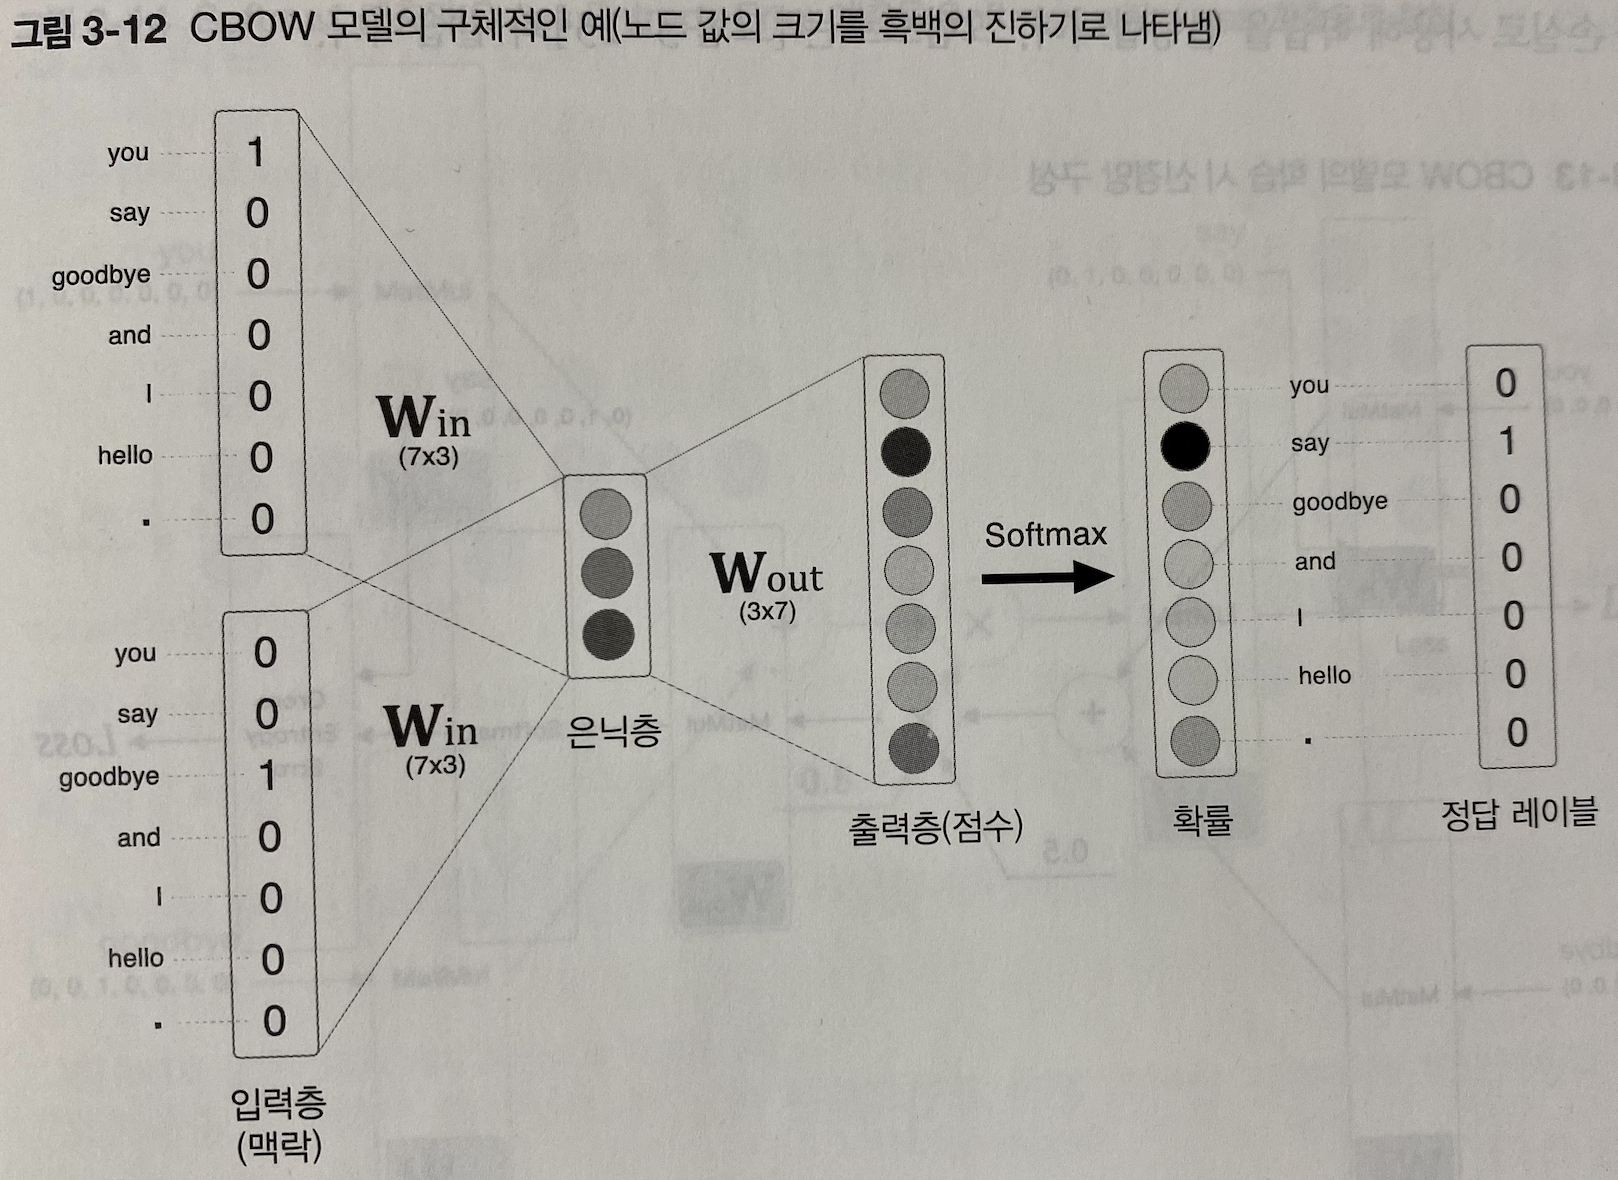

In [35]:
class CBOWClassifier(nn.Module): # Simplified cbow Model
    def __init__(self, vocabulary_size, embedding_size, padding_idx=0):
        """
        매개변수:
            vocabulary_size (int): 어휘 사전 크기, 임베딩 개수와 예측 벡터 크기를 결정합니다
            embedding_size (int): 임베딩 크기
            padding_idx (int): 기본값 0; 임베딩은 이 인덱스를 사용하지 않습니다
        """
        super(CBOWClassifier, self).__init__()
        
        self.embedding =  nn.Embedding(num_embeddings=vocabulary_size, 
                                       embedding_dim=embedding_size,
                                       padding_idx=padding_idx)
        self.fc1 = nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size)

    def forward(self, x_in, apply_softmax=False):
        """분류기의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서 
                x_in.shape는 (batch, input_dim)입니다.
            apply_softmax (bool): 소프트맥스 활성화 함수를 위한 플래그
                크로스-엔트로피 손실을 사용하려면 False로 지정합니다
        반환값:
            결과 텐서. tensor.shape은 (batch, output_dim)입니다.
        """
        x_embedded_sum = F.dropout(self.embedding(x_in).sum(dim=1), 0.3)
        y_out = self.fc1(x_embedded_sum)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out

## 모델 훈련

### 헬퍼 함수

In [36]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """ 훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### 일반 유틸리티

In [37]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### 설정과 전처리 작업

In [38]:
args = Namespace(
    # 날짜와 경로 정보
    cbow_csv="data/books/frankenstein_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch5/cbow",
    # 모델 하이퍼파라미터
    embedding_size=50,
    # 훈련 하이퍼파라미터
    seed=1337,
    num_epochs=100,
    learning_rate=0.0001,
    batch_size=32,
    early_stopping_criteria=5,
    # 실행 옵션
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("CUDA 사용여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	model_storage/ch5/cbow/vectorizer.json
	model_storage/ch5/cbow/model.pth
CUDA 사용여부: True


### 초기화

In [9]:
# # 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 라이트 버전의 데이터를 다운로드하세요.
# !mkdir data
# !wget https://git.io/JtX5A -O data/download.py
# !wget https://git.io/JtX5F -O data/get-all-data.sh
# !chmod 755 data/get-all-data.sh
# %cd data
# !./get-all-data.sh
# %cd ..

mkdir: cannot create directory ‘data’: File exists
--2022-04-13 16:03:50--  https://git.io/JtX5A
Resolving git.io (git.io)... 54.162.128.250, 18.205.36.100, 54.157.58.70, ...
Connecting to git.io (git.io)|54.162.128.250|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_2_CBOW/data/download.py [following]
--2022-04-13 16:03:51--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_2_CBOW/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2022-04-13 16:03:52 (29.0 MB/s) - ‘data/d

In [39]:
# dataset, vectorizer 생성

if args.reload_from_files:
    print("데이터셋과 Vectorizer를 로드합니다")
    dataset = CBOWDataset.load_dataset_and_load_vectorizer(args.cbow_csv,
                                                           args.vectorizer_file)
else:
    print("데이터셋을 로드하고 Vectorizer를 만듭니다")
    dataset = CBOWDataset.load_dataset_and_make_vectorizer(args.cbow_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = CBOWClassifier(vocabulary_size=len(vectorizer.cbow_vocab), 
                            embedding_size=args.embedding_size)

데이터셋을 로드하고 Vectorizer를 만듭니다


### 훈련 반복

In [24]:
classifier = classifier.to(args.device)
    
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size), 
                               position=1, 
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size), 
                             position=1, 
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------
            
            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 바 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred =  classifier(x_in=batch_dict['x_data'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/1984 [00:00<?, ?it/s]

split=val:   0%|          | 0/425 [00:00<?, ?it/s]

In [40]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(x_in=batch_dict['x_data'])
    
    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [41]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 7.7003502913082285;
테스트 정확도: 13.249999999999993


### 훈련된 임베딩

In [42]:
def pretty_print(results):
    """
    임베딩 결과를 출력합니다
    """
    for item in results:
        print ("...[%.2f] - %s"%(item[1], item[0]))

def get_closest(target_word, word_to_idx, embeddings, n=5):
    """
    n개의 최근접 단어를 찾습니다.
    """

    # 다른 모든 단어까지 거리를 계산합니다
    word_embedding = embeddings[word_to_idx[target_word.lower()]]
    distances = []
    for word, index in word_to_idx.items():
        if word == "<MASK>" or word == target_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    results = sorted(distances, key=lambda x: x[1])[1:n+2]
    return results

In [44]:
word = input('단어를 입력해 주세요: ')
embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx
pretty_print(get_closest(word, word_to_idx, embeddings, n=5))

단어를 입력해 주세요:  science


...[7.00] - mutual
...[7.03] - impression
...[7.04] - mist
...[7.19] - swelling
...[7.25] - darkened
...[7.28] - gospel


In [45]:
target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely', 'happy']

embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx

for target_word in target_words: 
    print(f"======={target_word}=======")
    if target_word not in word_to_idx:
        print("Not in vocabulary")
        continue
    pretty_print(get_closest(target_word, word_to_idx, embeddings, n=5))

=======frankenstein=======
...[7.20] - irradiated
...[7.67] - men
...[7.67] - enslaved
...[7.73] - austria
...[7.74] - wound
...[7.74] - professor
=======monster=======
...[7.50] - cares
...[7.68] - griefs
...[7.77] - saw
...[7.77] - without
...[7.78] - trifling
...[7.79] - confused
=======science=======
...[7.00] - mutual
...[7.03] - impression
...[7.04] - mist
...[7.19] - swelling
...[7.25] - darkened
...[7.28] - gospel
=======sickness=======
...[6.24] - while
...[6.58] - awoke
...[6.59] - foundations
...[6.70] - consoles
...[6.72] - know
...[6.74] - literally
=======lonely=======
...[6.69] - unveiled
...[6.84] - ought
...[6.93] - moonlight
...[7.08] - bed
...[7.15] - three
...[7.16] - superhuman
=======happy=======
...[6.31] - bottom
...[6.38] - wand
...[6.41] - penetrated
...[6.49] - altered
...[6.50] - aid
...[6.54] - danger
